In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(100)
%load_ext autoreload
%autoreload 2

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.6, df = 4, n_sources = NumberofSources, size_sources = N , decreasing_correlation = True)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

print("The following is the mixture matrix A")
display_matrix(A)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 27.39168462764292


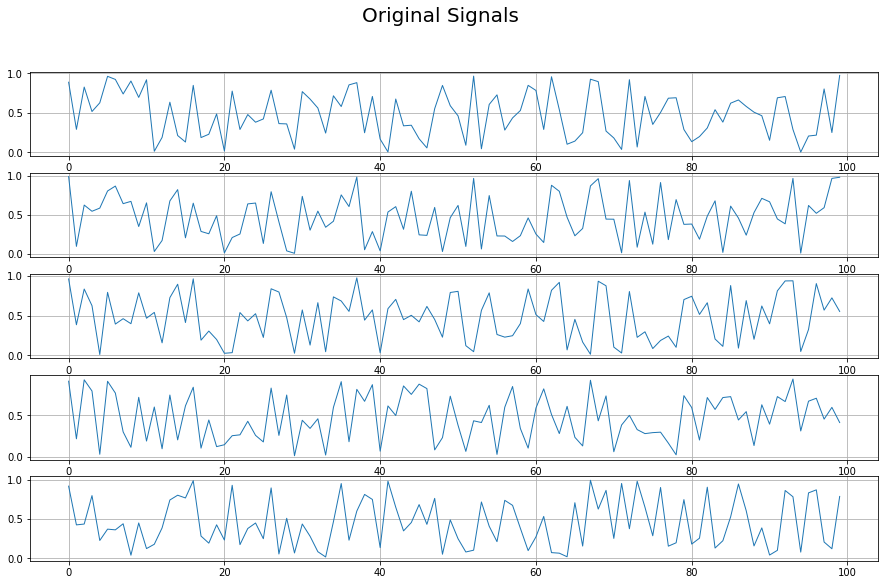

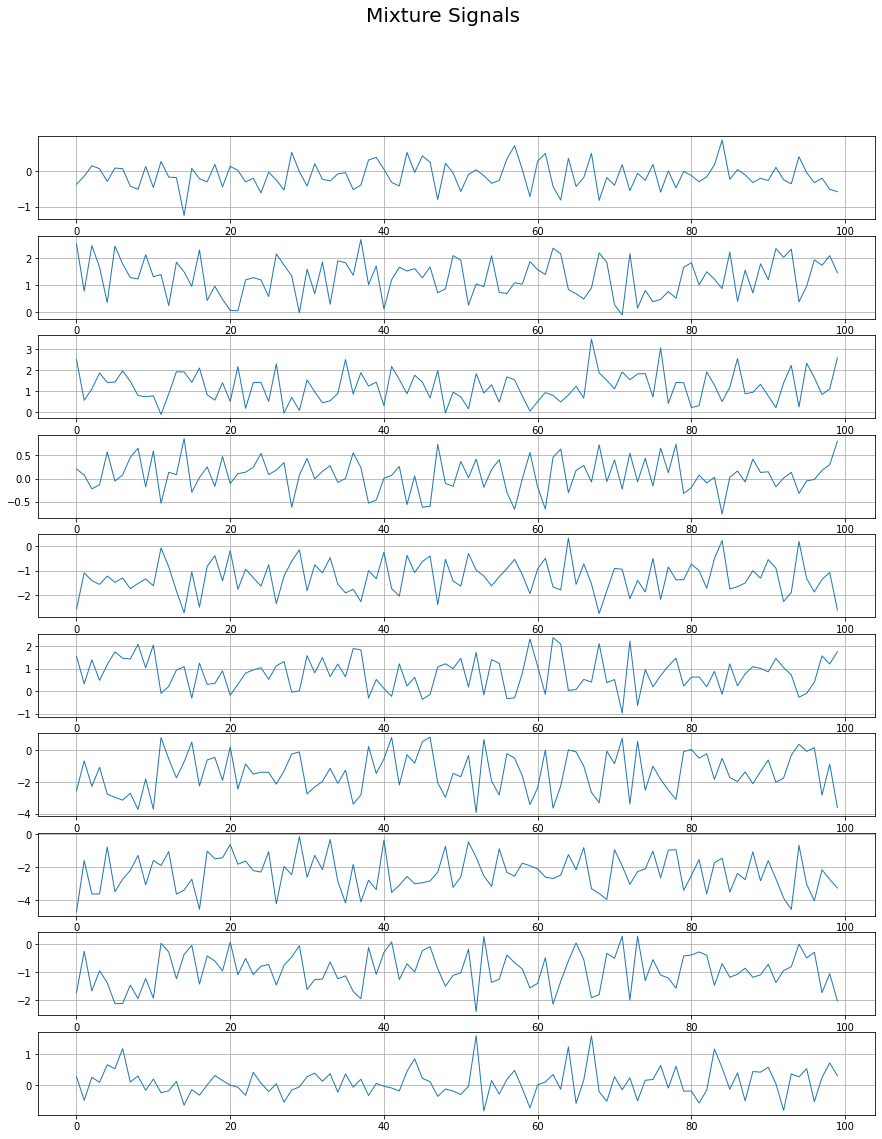

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [5]:
lambday = 1 - 1e-6/15
lambdae = 1 - 1e-7/15

s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 120 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 4e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

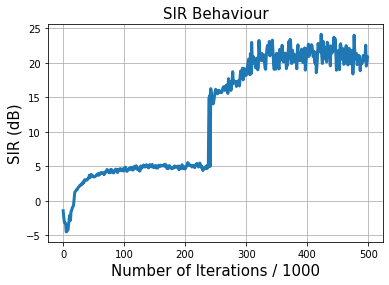

100%|█████████████████████████████████| 500000/500000 [01:32<00:00, 5403.82it/s]


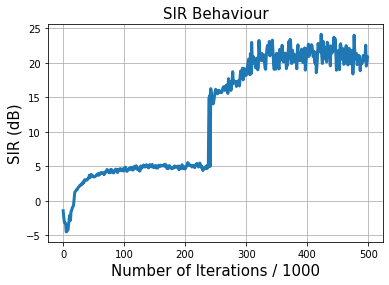

In [6]:
model.fit_batch_nnantisparse(X = X, beta = 6, n_epochs = 1, neural_dynamic_iterations = 10,
                             plot_in_jupyter = True, neural_lr_start = .12,
                             neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                             shuffle = True)

Final SIR: 20.873490316541282


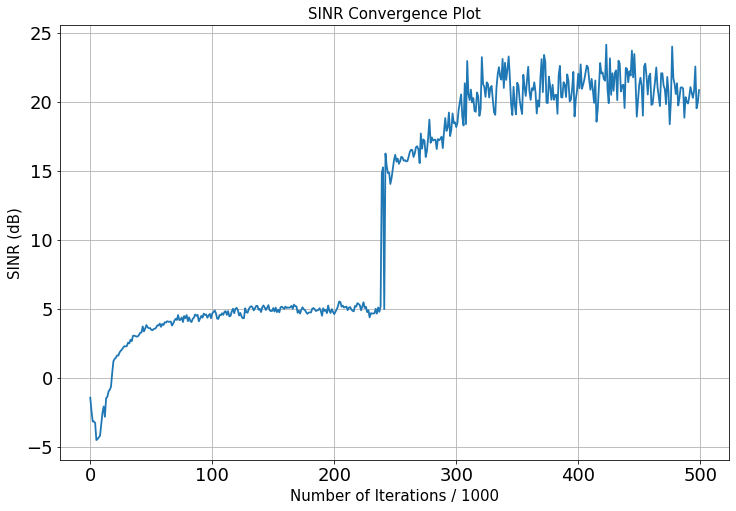

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))